In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

from zipfile import ZipFile
! cp '/content/drive/MyDrive/ML_Capstone/drive-download.zip' '/content'
from zipfile import ZipFile
zip = ZipFile('/content/drive-download.zip')
zip.extractall()

Mounted at /content/drive/


In [ ]:
# importing required packages
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import numpy as np
import cv2
import pickle as pkl
import matplotlib.pyplot as plt
from torchvision import models
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import train_test_split
import pandas as pd

# Dataset and Dataloaders

In [ ]:
# Set device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Lazy Loading

data
-train
  - X
    - 1
      - rgb
        - 0.png
        - 1.png
        - 2.png
      - depth.npy
      - field_id.pkl
    
    - 2

    - ...
  - Y
    - 1.npy
    - 2.npy

-test

In [ ]:
class LazyLoadDataset(Dataset):
  def __init__(self,path,train=True,transform=None):
    self.train = train
    self.transform = transform
    path = path + ("train/" if self.train else "test/")

    self.pathX = path + "X/"
    self.pathY = path + "Y/"

    self.data = os.listdir(self.pathX)

  def __getitem__(self,idx):
    f = self.data[idx]

    # X
    # read rgb images
    img0 = cv2.imread(self.pathX + f + "/rgb/0.png")[:,:,1:]/255
    img0 = np.resize(img0,(224,224,2))
    #print(img0.shape)

    # read depth images
    depth = np.load(self.pathX + f + "/depth.npy")[0]/1000
    depth = np.resize(depth,(224,224,1))

    stacked = np.concatenate((img0, depth), axis=2)

    if self.transform is not None:
      stacked = self.transform(stacked)

    # read field ID
    field_id = pkl.load(open(self.pathX + f + "/field_id.pkl","rb"))

    if self.train==True:
      # Y 
      Y = np.load(self.pathY + f + ".npy")*1000
      return (stacked.float().type(torch.float32),field_id),torch.from_numpy(Y).float().type(torch.float32)

    else: # if test, there is no Y
      return stacked.float().type(torch.float32),field_id

  def __len__(self):
    return len(self.data)


# Normalization: Compute Mean and Std

In [ ]:
train_dataset_raw = LazyLoadDataset("/content/",train=True,transform=ToTensor()) 
means=[]
stds=[]
for i in range(3396):
  (stacked_i, id_i),Y_i=train_dataset_raw[i]
  means.append([torch.mean(stacked_i[0]).item(),torch.mean(stacked_i[1]).item(),torch.mean(stacked_i[2]).item()])
  stds.append([torch.std(stacked_i[0]).item(),torch.std(stacked_i[1]).item(),torch.std(stacked_i[2]).item()])

In [ ]:
stacked_i

In [ ]:
means

In [ ]:
norm_mean=np.mean(means,axis =0)
norm_mean = list(norm_mean)
norm_mean

[0.41699021958139393, 0.3959879955305368, 0.6557701463834136]

In [ ]:
norm_std=np.mean(stds,axis=0)
norm_std = list(norm_std)
norm_std

[0.1986706505394656, 0.21113784175510963, 0.40322135255460323]

# Train Dataset & Train loader



In [ ]:
#transform=transforms.Compose([transforms.ToTensor()])
train_dataset = LazyLoadDataset("/content/",transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std)])) 

In [ ]:
(stacked, field_id), Y = train_dataset[0]

In [ ]:
stacked.shape

torch.Size([3, 224, 224])

In [ ]:
batch_size_train = 4
train_loader=DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)

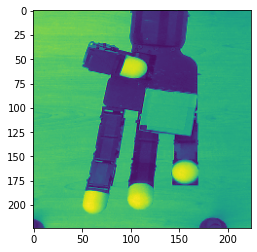

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  plt.imshow(data[0][0][0])
  break

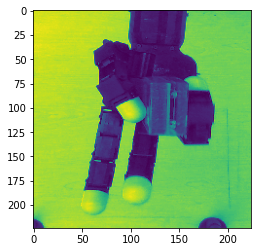

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  plt.imshow(data[0][0][1])
  break

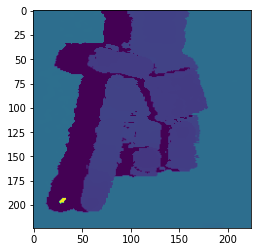

In [ ]:
for batch_idx, (data, target) in enumerate(train_loader):
  plt.imshow(data[0][0][2])
  break

# Test Dataset & Test loader

In [ ]:
test_dataset = LazyLoadDataset("/content/",train=False,transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(norm_mean, norm_std),
                   ])) 

batch_size_test = 2
test_loader=DataLoader(test_dataset,batch_size=batch_size_test,shuffle=True)

# Model

In [ ]:
class CNN(nn.Module):
    def __init__(self, input_channels, conv_feature, fc_feature, output_size):
        super(CNN, self).__init__()
        
        # We use Sequential for simplicity
        self.stack = nn.Sequential(nn.Conv2d(input_channels, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   nn.Conv2d(conv_feature, conv_feature,kernel_size=5),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                   
                                   nn.Flatten(),
                                   nn.Linear(conv_feature*53*53, fc_feature),
                                   nn.ReLU(),
                                   nn.Linear(fc_feature, output_size)
        )
                 
                                   
                                  
    def forward(self, x):
        x = self.stack(x)
        return x

In [ ]:
# Model input/output settings
input_channels = 3
conv_feature = 6 
fc_feature = 50
output_size=12

In [ ]:
def train(epoch, model, optimizer,loader=train_loader):
    """
    Train the model for one epoch

    Args:
        epoch (int): current epoch
        model (nn.Module): model to train
        optimizer (torch.optim): optimizer to use
        permute_pixels (function): function to permute the pixels (default: None)
        permutation_order (1D torch array): order of the permutation (default: None)
    """
    model.train()
    for batch_idx,((data, id),target) in enumerate(loader):
        # send to device
        data, target = data.to(device), target.to(device)
        data = data.view(len(id),3,224, 224)

        # consider passing different data augmentation in training
        # data = F.invert()
        # data = F.adjust_sharpness(data,sharpness_factor = 0.5)
        # data = F.adjust_hue(data,hue_factor = 0.9)
        # data = F.adjust_saturation(data,saturation_factor = 0.5)

        # make sure we erase all the gradients before computing new ones
        optimizer.zero_grad() 
        
        # forward propagation
        output = model(data)
        #print(output.dtype)

        #RMSE loss
        loss = torch.sqrt(nn.functional.mse_loss(output,target))
        
        # backward propagation
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss))
            

In [ ]:
def test(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    ids = []
    preds = []
    with torch.no_grad():
      for batch_idx,(data, id) in enumerate(test_loader):
        # send to device
        data = data.to(device)          
        pred = model(data)
        for i in range(len(id)):
          ids.append(id[i])
          preds.append(np.array(pred[i].cpu()/1000,dtype="float64"))

    return ids, preds  
    

# Cross-Validation & Grid-Search for determining hyperparameters

What should hyperparameters in the models be? We could perform grid-search on the whole train dataset and pick the best-performing hyerparameters. But to avoid over-fitting on the train dataset, we split the whole train dataset into 9:1.




*   cross_val_train_set (90% of train dataset)
*   cross_val_test_set (10% of train dataset)


We train our model on the cross_val_train_set and test our model on cross_val_test_set. We pick the best-performing hyperparameters on the cross_val_test_set.

After all these steps, we train our model using the picked hyperparameters on the whole train dataset.

In [ ]:
cross_val_train_set, cross_val_test_set = train_test_split(train_dataset, test_size=0.1)

In [ ]:
# Sanity Check
len(cross_val_train_set) == int(len(train_dataset)*0.9)
len(cross_val_train_set)

3056

In [ ]:
batch_size_cross_val_train = 4
batch_size_cross_val_test = len(cross_val_test_set) # = 340
len(cross_val_test_set)

340

In [ ]:
cross_val_train_loader=DataLoader(cross_val_train_set,batch_size=batch_size_cross_val_train,shuffle=True)
cross_val_test_loader=DataLoader(cross_val_test_set,batch_size=batch_size_cross_val_test,shuffle=True)

In [ ]:
len(cross_val_test_loader)

1

In [ ]:
def cross_val(model):
    """
    Test the model

    Args:
        model (nn.Module): model to test
      
    """
    model.eval()
    # We can just edit on the code for train(). We should delete the bakward propagation part and optimizer part.

    with torch.no_grad():
      for batch_idx,((data, id),target) in enumerate(cross_val_test_loader):
          # send to device
          if batch_idx==0:
            data, target = data.to(device), target.to(device)
            
            # forward propagation
            output = model(data)

            #RMSE loss
            loss = torch.sqrt(nn.functional.mse_loss(output,target)) 
            return loss.item()

In [ ]:
def SGD_hyper_tuning(lr_list,momentum_list):  
  for j in momentum_list:
    for i in lr_list:
      model_cnn = CNN(input_channels, conv_feature, fc_feature, output_size) # create CNN model
      model_cnn.to(device)
      print("lr=",i,"momentum=",j)
      train(epoch=0, model=model_cnn, optimizer=torch.optim.SGD(model_cnn.parameters(), lr=i,momentum=j),loader=cross_val_train_loader)
      print("Validation Performance:",cross_val(model_cnn))

In [ ]:
lr_list = [1e-5,1e-4,1e-3,1e-2,1e-1]
momentum_list = [0.99,0.97,0.95,0.93,0.91]
SGD_hyper_tuning(lr_list,momentum_list)

lr= 1e-05 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.294220
Train Epoch: 0 [800/3056 (26%)]	Loss: 65.471962
Train Epoch: 0 [1600/3056 (52%)]	Loss: 41.017929
Train Epoch: 0 [2400/3056 (79%)]	Loss: 29.311810
Validation Performance: 20.84676170349121
lr= 0.0001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 69.698975
Train Epoch: 0 [800/3056 (26%)]	Loss: 35.812199
Train Epoch: 0 [1600/3056 (52%)]	Loss: 21.611507
Train Epoch: 0 [2400/3056 (79%)]	Loss: 16.005093
Validation Performance: 12.62244701385498
lr= 0.001 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 65.099464
Train Epoch: 0 [800/3056 (26%)]	Loss: 23.699581
Train Epoch: 0 [1600/3056 (52%)]	Loss: 20.786964
Train Epoch: 0 [2400/3056 (79%)]	Loss: 22.827841
Validation Performance: 62.96582794189453
lr= 0.01 momentum= 0.99
Train Epoch: 0 [0/3056 (0%)]	Loss: 66.256699
Train Epoch: 0 [800/3056 (26%)]	Loss: 27.031967
Train Epoch: 0 [1600/3056 (52%)]	Loss: 22.820616
Train Epoch: 0 [2400/3056 (79%)]	Loss: 17.629749
Validation

Its performance is worse than CNN with pure img0 or depth input.